In [1]:
# This notebook was run on a simple laptop with 8GB RAM and core i5-1135G7 @ 2.40GHz
import sys
new_paths = [r'../datasets', r'../utils',r'../Passive_sampling']
for path in new_paths:
    sys.path.insert(0, path)
import warnings
warnings.filterwarnings("ignore")
from sampling_process import sampler
from plots import generate_lineplots
from Datasets_Class import Dataset

import numpy as np
from tqdm import tqdm
import pandas as pd
import h5py

import random
from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr, pearsonr

# Sklearn
from sklearn.metrics import mean_absolute_error, root_mean_squared_error , pairwise_distances
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV




# 1. Download and Read Data

The 'Dataset' class can be used to download and read the datasets. It takes as input the path to the folder where the datasets will be downloaded. Once you have created the 'Dataset' class object, you can use the QM7_dataset, QM8_dataset, QM9_dataset modules to access the respective datasets. The modules download the respective datasets, preprocess them as described in the paper, and return a data feature matrix 'x' and associated labels 'y'

In [2]:
datasets =  Dataset('../datasets')
x, y = datasets.QM7_dataset()
print('Shape data matrix:', x.shape)
'''
# Use one of the functions below to replicate the experiments on the QM8, QM9 or ZINC using the KRR.
# The QM8 dataset may take up to several minutes for the data preprocessing.  The QM9 may take up to ours for the data preprocessing.

x, y = datasets.QM8_dataset(pca=100)
print('Shape data matrix:', x.shape)

x, y = datasets.QM9_dataset(normalize = True, pca=100)
print('Shape data matrix:', x.shape)

x, y = datasets.ZINC_dataset()
print('Shape data matrix:', x.shape)

'''

Download successful. Data saved to ../datasets/data_qm7/qm7.mat
Shape data matrix: (7165, 276)


"\n# Use one of the functions below to replicate the experiments on the QM8, QM9 or ZINC using the KRR.\n# The QM8 dataset may take up to several minutes for the data preprocessing.  The QM9 may take up to ours for the data preprocessing.\n\nx, y = datasets.QM8_dataset(pca=100)\nprint('Shape data matrix:', x.shape)\n\nx, y = datasets.QM9_dataset(normalize = True, pca=100)\nprint('Shape data matrix:', x.shape)\n\nx, y = datasets.ZINC_dataset()\nprint('Shape data matrix:', x.shape)\n\n"

# 2. Data Selection
The sampler function computes train/test data splits according to the sampling strategies considered in the paper. It takes into input the data matrix x with shape (n_samples, n_features), the path where to save the h5py file containing the data splits,  a list of the sampling strategies of interest, the training set sizes and the initial conditions, that is, the index of the initially selected point for greedy algorithms and different seeds for the others.  Note thatm we have two implementations of the DA-FPS. The first in pytorch ('DA-FPS_torch'), and the second in numpy ('DA-FPS').

In [3]:
def select_random_indices(n, m, seed=None):
    random.seed(seed)
    num_list = list(range(n))
    random_indices = random.sample(num_list, m)
    return random_indices

seed = 123  # Set seed for reproducibility
initial_conditions = select_random_indices(len(x), 5, seed) # Number of inital conditions
print(initial_conditions)

trainig_set_sizes =  [int((len(x)/100)*c) for c in [ 5, 10, 15, 20]]
strategies =  [ 'FPS', 'RDM', 'FacilityLocation', 'k-medoids++', 'FPS-RDM', 'FPS-FacLoc', 'FPS-k-medoids++', 'DA-FPS']
sampler(x,  "./Passive_sampling_QM7" , strategies, trainig_set_sizes, initial_conditions)

[428, 2192, 714, 6299, 3336]
DA-FPS numpy implementation


100%|██████████| 1219/1219 [00:04<00:00, 286.33it/s]


Running FPS...


100%|██████████| 1432/1432 [00:03<00:00, 438.88it/s]


Running RDM...
Running k-medoids++...


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Running FacilityLocation...


100%|██████████| 1.43k/1.43k [00:00<00:00, 1.54kit/s]
100%|██████████| 1.43k/1.43k [00:00<00:00, 1.62kit/s]
100%|██████████| 1.43k/1.43k [00:00<00:00, 1.69kit/s]
100%|██████████| 1.43k/1.43k [00:00<00:00, 1.58kit/s]
100%|██████████| 1.43k/1.43k [00:00<00:00, 1.50kit/s]


Running FPS-k-medoids++...


100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Running FPS-FacLoc...


100%|██████████| 213/213 [00:00<00:00, 453.49it/s]
100%|██████████| 1.22k/1.22k [00:00<00:00, 2.40kit/s]
100%|██████████| 213/213 [00:00<00:00, 446.15it/s]
100%|██████████| 1.22k/1.22k [00:00<00:00, 2.58kit/s]
100%|██████████| 213/213 [00:00<00:00, 464.12it/s]
100%|██████████| 1.22k/1.22k [00:00<00:00, 2.21kit/s]
100%|██████████| 213/213 [00:00<00:00, 459.80it/s]
100%|██████████| 1.22k/1.22k [00:00<00:00, 2.23kit/s]
100%|██████████| 213/213 [00:00<00:00, 440.09it/s]
100%|██████████| 1.22k/1.22k [00:00<00:00, 2.39kit/s]


Running FPS-RDM...


100%|██████████| 213/213 [00:00<00:00, 449.95it/s]


# 3. Molecular Property Prediction: KRR with Gaussian Kernel
## 3.1 Hyperparameters grid-search on random data
We perform hyperparameter search for the KRR using cross validation on randomly selected elements.

In [4]:

f = h5py.File("./Passive_sampling_QM7", "r")
hyperparameters = {'num_selected' : [],'alpha':  [], 'gamma' : []}

for size in tqdm(trainig_set_sizes):

    train_tags = f['RDM']['train_Initialize_1'][f'selected_{size}'][:]
    
    krr = KernelRidge()
    alpha = np.logspace(-6, -1, 6)
    gamma = np.logspace(-6, -1, 6)
    
    #Parameters grid
    parameters = { 'alpha':alpha, 'kernel':['rbf'], 'gamma':gamma}

    #Cross Validation
    clf = GridSearchCV(krr, parameters, cv=5, scoring = 'neg_mean_absolute_error',  verbose=0, n_jobs = -1)
    clf.fit(x[train_tags,:],y[train_tags])
    
    #Select best parameters
    alpha = clf.best_params_['alpha'] 
    gamma = clf.best_params_['gamma'] 
    
    #Save best parameters
    hyperparameters['num_selected'].append(size)
    hyperparameters['alpha'].append(alpha)
    hyperparameters['gamma'].append(gamma)

f.close()
hyperparameters_df = pd.DataFrame(data=hyperparameters)

100%|██████████| 4/4 [00:11<00:00,  2.84s/it]


# 3.2 Regression task


In [5]:
f = h5py.File("./Passive_sampling_QM7", "r")
alpha = hyperparameters_df['alpha'].mean()
gamma = hyperparameters_df['gamma'].mean()

d_a = {'strategy' : [], 'initialization' : [], 'num_selected' : [],  'MAE':  [],  'RMSE' : [] }

for size in tqdm(trainig_set_sizes):
    for ss in strategies:
        for init in [1,2,3,4,5]:
                
                    #Load indeces training and test set   
                    idx_train = f[ss][f'train_Initialize_{init}'][f'selected_{size}'][:]
                    idx_test = f[ss][f'test_Initialize_{init}'][f'selected_{size}'][:]
                
                    #Regression
                    krr = KernelRidge(alpha=alpha, kernel= 'rbf', gamma =gamma )
                    krr.fit(x[idx_train,:], y[idx_train]) 
      
                    #Prediction and errors computation
                    ypred = krr.predict(X=x[idx_test,:])
                    MAE = mean_absolute_error(y[idx_test], ypred) 
                    RMSE =root_mean_squared_error(y[idx_test], ypred)
                     
                    
                    # Save results in dictionary
                    d_a['strategy'].append(ss)
                    d_a['initialization'].append(init)
                    d_a['num_selected'].append(size)
                    d_a['MAE'].append(MAE)
                    d_a['RMSE'].append(RMSE)

df = pd.DataFrame(data=d_a)
df.to_csv('test_reuslt.csv')
f.close()

100%|██████████| 4/4 [00:32<00:00,  8.09s/it]


# 3.2.1 Plot results regression


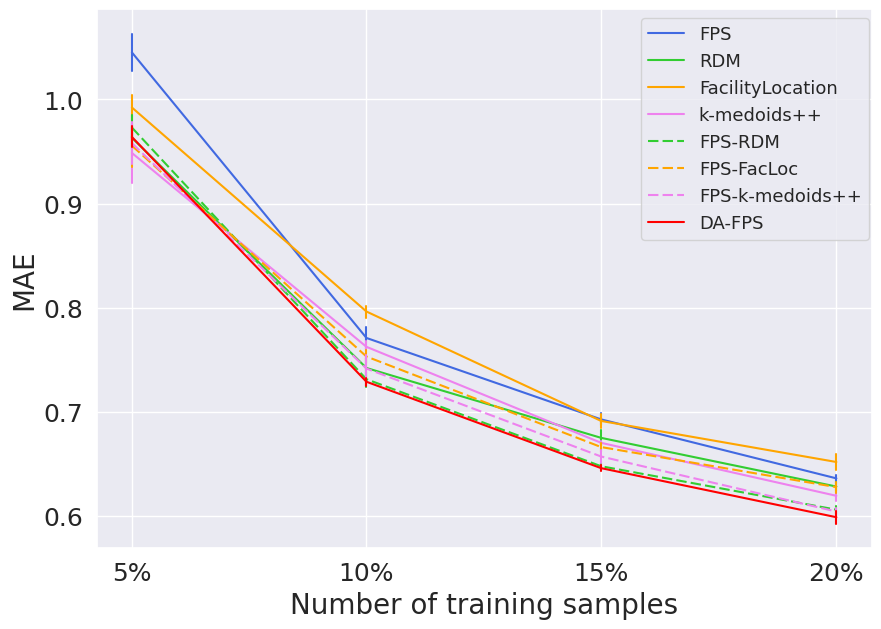

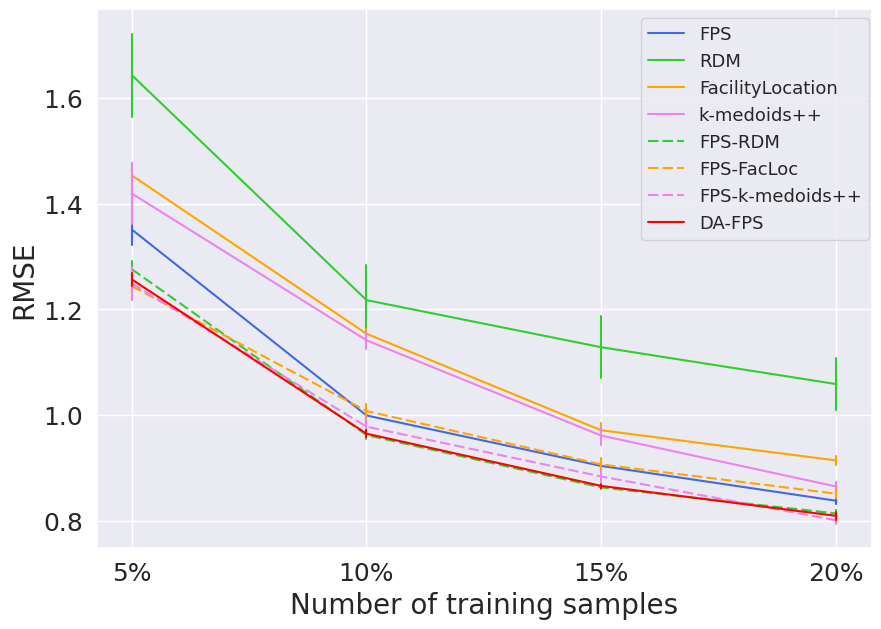

In [6]:
df = pd.read_csv('test_reuslt.csv')
strategies =  [ 'FPS', 'RDM', 'FacilityLocation', 'k-medoids++', 'FPS-RDM', 'FPS-FacLoc', 'FPS-k-medoids++', 'DA-FPS']
generate_lineplots('QM7',df, strategies)

# 4. Data assumptions
Compute Pearson's and Spearman's correlation coefficients. We expect the pairwise distances in feature and label space to be directly correlated for the experiments to ensure consistency with theory.

In [7]:
#Extracts the upper triangular elements from a matrix.
def upper_triangular(matrix):
    rows, cols = matrix.shape
    upper_diagonal_array = []
    for i in range(rows):
        for j in range(i + 1, cols):
            upper_diagonal_array.append(matrix[i, j])     
    upper_diagonal_array = np.array(upper_diagonal_array)
    return upper_diagonal_array

# Calculate pairwise distances for matrices x and y
dist_x = pairwise_distances(x,x, n_jobs=-1)
ut_x = upper_triangular(dist_x)

dist_y = pairwise_distances(y[:, np.newaxis], y[:, np.newaxis], n_jobs=-1)
ut_y = upper_triangular(dist_y)

# Calculate Spearman and Pearson correlation coefficients
pearson_cc, pearson_p_value = pearsonr(ut_x, ut_y)
spearman_cc, spearman_p_value = spearmanr(ut_x, ut_y)


# Print the correlation coefficients
print('Pearson correlation coefficient with atomization energy labels:', pearson_cc)
print('Spearman correlation coefficient with atomization energy labels:', spearman_cc)

Pearson correlation coefficient with atomization energy labels: 0.14862446
Spearman correlation coefficient with atomization energy labels: 0.2742620114854679
